In [1]:
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa as librosa
import librosa.display
import IPython.display as ipd
import pickle
import librosa
import librosa.display
import soundfile as sf

In [113]:
clip_length = 200

In [114]:

input_audio = keras.Input(shape = (1028,clip_length,1))

x = layers.Conv2D(16,(3,3), activation ='relu', padding = 'same')(input_audio)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(8,(3,3), activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(8,(3,3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D((2,2), padding = 'same')(x)

x = layers.Conv2D(8,(3,3), activation ='relu', padding = 'same')(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(8,(3,3), activation ='relu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16,(3,3), activation = 'relu')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1,(3,3), activation = 'sigmoid', padding = 'same')(x)

autoencoder = keras.Model(input_audio, decoded)

In [115]:
autoencoder.compile(optimizer='adam', loss = 'binary_crossentropy')

In [116]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1028, 200, 1)]    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1028, 200, 16)     160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 514, 100, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 514, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 257, 50, 8)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 257, 50, 8)        584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 129, 25, 8)        0   

In [117]:
# (x_train, _), (x_test,_) = mnist.load_data()
# x_train = x_train.astype('float32')/255
# x_test = x_test.astype('float32')/255
# x_train = np.reshape(x_train, (len(x_train),28,28,1))
# x_test = np.reshape(x_test, (len(x_test), 28,28,1))
# y_train = np.copy(x_train)
# x_train += np.random.rand(*x_train.shape)*.7
# x_train = np.minimum(x_train, 1)

In [ ]:
spec_ds = pickle.load(open('../connor/noise_dataset/spectrograms.bin', 'rb'))

In [ ]:
clean, dirty = spec_ds['clean'], spec_ds['dirty']
train_count = 8000
x_train, y_train = dirty[:train_count], clean[:train_count]
x_test, y_test = dirty[train_count-1:], clean[train_count-1:]

x_train, y_train = [(x + 80) / 80 for x in x_train if x.shape[1] >= clip_length], [(x + 80) / 80 for x in y_train if x.shape[1] >= clip_length]
x_test, y_test = [(x + 80) / 80 for x in x_test if x.shape[1] >= clip_length], [(x + 80) / 80 for x in y_test if x.shape[1] >= clip_length]

In [ ]:
min([x.shape[1] for x in x_test])

In [ ]:
nx_train, ny_train = np.zeros((len(x_train), 1028, clip_length)), np.zeros((len(y_train), 1028, clip_length))
nx_test, ny_test = np.zeros((len(x_test), 1028, clip_length)), np.zeros((len(y_test), 1028, clip_length))
for i in range(len(x_train)):
    offset = np.random.randint(0, x_train[i].shape[1]-clip_length+1)
    nx_train[i, :1025, :] = x_train[i][:, offset:(offset+clip_length)]
    ny_train[i, :1025, :] = y_train[i][:, offset:(offset+clip_length)]
    
for i in range(len(x_test)):
    offset = np.random.randint(0, x_test[i].shape[1]-clip_length+1)
    nx_test[i, :1025, :] = x_test[i][:, offset:(offset+clip_length)]
    ny_test[i, :1025, :] = y_test[i][:, offset:(offset+clip_length)]

nx_train, ny_train = nx_train.reshape(*nx_train.shape, 1), ny_train.reshape(*ny_train.shape, 1)
nx_test, ny_test = nx_test.reshape(*nx_test.shape, 1), ny_test.reshape(*ny_test.shape, 1)

In [ ]:
nx_train.shape

In [ ]:
def plot_spectogram(y):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    
    fig
def plot_stft(stft):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    img = librosa.display.specshow(stft, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    
    fig

In [ ]:
sr = 22050

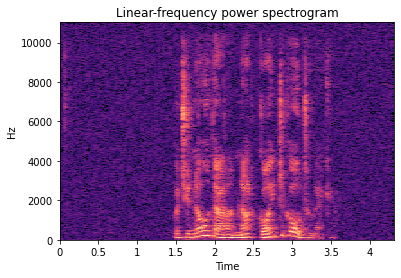

In [13]:
plot_stft(x_train[0])

In [14]:
from keras.callbacks import TensorBoard
autoencoder.fit(nx_train, ny_train, epochs = 5, batch_size=128, shuffle=True, validation_data = (nx_test, nx_test))

Epoch 1/5
63/63 [==============================] - 179s 3s/step - loss: 0.5708 - val_loss: 0.7283
Epoch 2/5
63/63 [==============================] - 173s 3s/step - loss: 0.4260 - val_loss: 0.7602
Epoch 3/5
63/63 [==============================] - 172s 3s/step - loss: 0.4105 - val_loss: 0.7086
Epoch 4/5
63/63 [==============================] - 173s 3s/step - loss: 0.3890 - val_loss: 0.7775
Epoch 5/5
63/63 [==============================] - 174s 3s/step - loss: 0.3764 - val_loss: 0.7742


In [15]:
decoded_audio = autoencoder.predict(nx_test)

In [91]:
i = 12

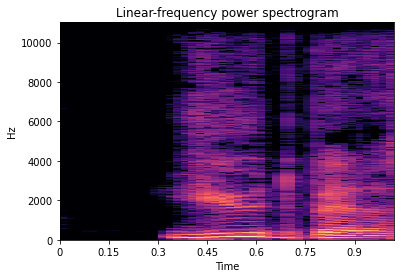

In [92]:
plot_stft(ny_test[i].reshape(1028, 44))

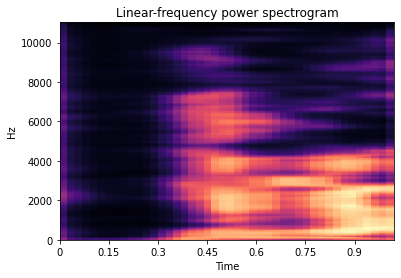

In [98]:
plot_stft(decoded_audio[i].reshape(1028, 44))

In [109]:
sf.write('stereo_original.wav', librosa.istft(librosa.db_to_amplitude(ny_test[i].reshape(1028, 44)[:1025, :] * 80 - 80) * 300), 18000, 'PCM_24')

In [ ]:
y = librosa.istft(librosa.db_to_amplitude(decoded_audio[i].reshape(1028, 44)[:1025, :] * 80 - 80) * 300)
plt.plot(y)

In [110]:
sf.write('stereo_file.wav', y, 18000, 'PCM_24')

In [105]:
nx_test[i]

array([[[0.        ],
        [0.        ],
        [0.18531637],
        ...,
        [0.4217853 ],
        [0.33485284],
        [0.0749568 ]],

       [[0.13382626],
        [0.1393117 ],
        [0.15378571],
        ...,
        [0.41032773],
        [0.41180378],
        [0.33656988]],

       [[0.21738334],
        [0.18262263],
        [0.07334614],
        ...,
        [0.32046762],
        [0.45906106],
        [0.42026439]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [66]:
b = librosa.db_to_amplitude(nx_test[i].reshape(1028, 44)[:1025, :] * 80 - 80) * 100

In [67]:
sf.write('stereo_in.wav', librosa.istft(b), 20000, 'PCM_24')